<a href="https://colab.research.google.com/github/EduardoLDB2001/Airbnb-IEEE/blob/main/Airbnb_IEEE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importação


In [ ]:
import pandas as pd
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import ast
from sklearn.ensemble import RandomForestRegressor

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dtype_spec = {
    'id': 'str',
    'host_listings_count': 'str',
    'accommodates': 'str',
    'minimum_nights': 'str'
    }

test = pd.read_csv('/content/drive/MyDrive/cr.io/Gestão/Projetos/Projetos/IEEE/Airbnb/test.csv')

In [ ]:
dtype_spec = {
    'id': 'str',
    'host_listings_count': 'str',
    'accommodates': 'str',
    'minimum_nights': 'str'
    }

train = pd.read_csv('/content/drive/MyDrive/cr.io/Gestão/Projetos/Projetos/IEEE/Airbnb/train.csv', dtype=dtype_spec)

#Tratamento

##Train

#### Limpeza de dados

In [ ]:
# Deletar linhas e colunas em branco
train = train.dropna(axis=1, how='all')
train = train.dropna(axis=0, how='all')

# Deletar colunas irrelevantes para o modelo
train = train.drop(['name', 'summary', 'space', 'description', 'neighborhood_overview', 'listing_url', 'last_scraped', 'scrape_id'], axis=1)

#### Ajuste de formato de dados

In [ ]:
# Ajustar colunas com necessidade de substituição ou retirada de valores
train['instant_bookable'] = train['instant_bookable'].replace({'t': 1, 'f': 0})
train['instant_bookable'] = train['instant_bookable'].fillna(0).astype('int64')

train['experiences_offered'] = train['experiences_offered'].replace('none', 0)
train['experiences_offered'] = train['experiences_offered'].astype(float).fillna(0).astype('int64')

train['host_is_superhost'] = train['host_is_superhost'].replace({'t': 1, 'f': 0})
train['host_is_superhost'] = train['host_is_superhost'].fillna(0).astype('int64')

train = train[train['extra_people'] != 'moderate']
train['extra_people'] = train['extra_people'].str.replace('$', '', regex=False)
train['extra_people'] = train['extra_people'].str.replace(',', '', regex=False).astype(float)

train = train[train['accommodates'] != '2019-03-06']
train['accommodates'] = train['accommodates'].fillna(0).astype('int64')

train['price'] = train['price'].str.replace('$', '', regex=False)
train['price'] = train['price'].str.replace(',', '', regex=False).astype(float)


# Ajustar formatos de dados
train['minimum_minimum_nights'] = train['minimum_minimum_nights'].fillna(0).astype('int64')
train['maximum_minimum_nights'] = train['maximum_minimum_nights'].fillna(0).astype('int64')
train['minimum_maximum_nights'] = train['minimum_maximum_nights'].fillna(0).astype('int64')
train['maximum_maximum_nights'] = train['maximum_maximum_nights'].fillna(0).astype('int64')
train['number_of_reviews_ltm'] = train['number_of_reviews_ltm'].fillna(0).astype('int64')
train['calculated_host_listings_count_entire_homes'] = train['calculated_host_listings_count_entire_homes'].fillna(0).astype('int64')
train['calculated_host_listings_count_private_rooms'] = train['calculated_host_listings_count_private_rooms'].fillna(0).astype('int64')
train['calculated_host_listings_count_shared_rooms'] = train['calculated_host_listings_count_shared_rooms'].fillna(0).astype('int64')
train['bathrooms'] = train['bathrooms'].fillna(0).astype('int64')
train['bedrooms'] = train['bedrooms'].fillna(0).astype('int64')
train['beds'] = train['beds'].fillna(0).astype('int64')
train['number_of_reviews'] = train['number_of_reviews'].fillna(0).astype('int64')
train['minimum_nights'] = train['minimum_nights'].fillna(0).astype('int64')
train['host_listings_count'] = train['host_listings_count'].str.replace(',', '', regex=False).astype(float)





In [ ]:
# Contar o número de vezes que o valor 'moderate' aparece na coluna 'extra_people'
count_moderate = train['extra_people'].value_counts().get('moderate', 0)

# Exibir a contagem
print(f"Contagem de valores 'moderate': {count_moderate}")

Contagem de valores 'moderate': 0


#### Tratamento de dados nulos

In [ ]:
# Mostrar informações do DataFrame
train.info()

# Mostrar porcentagem de linhas com valores em branco
total_rows = len(train)
rows_with_nulls = train.isnull().any(axis=1).sum()
percentage_rows_with_nulls = (rows_with_nulls / total_rows) * 100

print(f"Porcentagem de linhas com algum valor em branco: {percentage_rows_with_nulls:.2f}%")

# Criar tabela de porcentagem de valores em branco por coluna
null_percentage_per_column = train.isnull().mean() * 100
null_percentage_train = null_percentage_per_column.reset_index()
null_percentage_train.columns = ['Column', 'Percentage of Nulls']

print(null_percentage_train)


<class 'pandas.core.frame.DataFrame'>
Index: 588090 entries, 0 to 588090
Data columns (total 29 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   id                                            588090 non-null  object 
 1   experiences_offered                           588090 non-null  int64  
 2   minimum_minimum_nights                        588090 non-null  int64  
 3   maximum_minimum_nights                        588090 non-null  int64  
 4   minimum_maximum_nights                        588090 non-null  int64  
 5   maximum_maximum_nights                        588090 non-null  int64  
 6   minimum_nights_avg_ntm                        451121 non-null  float64
 7   maximum_nights_avg_ntm                        451121 non-null  float64
 8   number_of_reviews_ltm                         588090 non-null  int64  
 9   calculated_host_listings_count_entire_homes   588090 

##### minimum_nights_avg_ntm

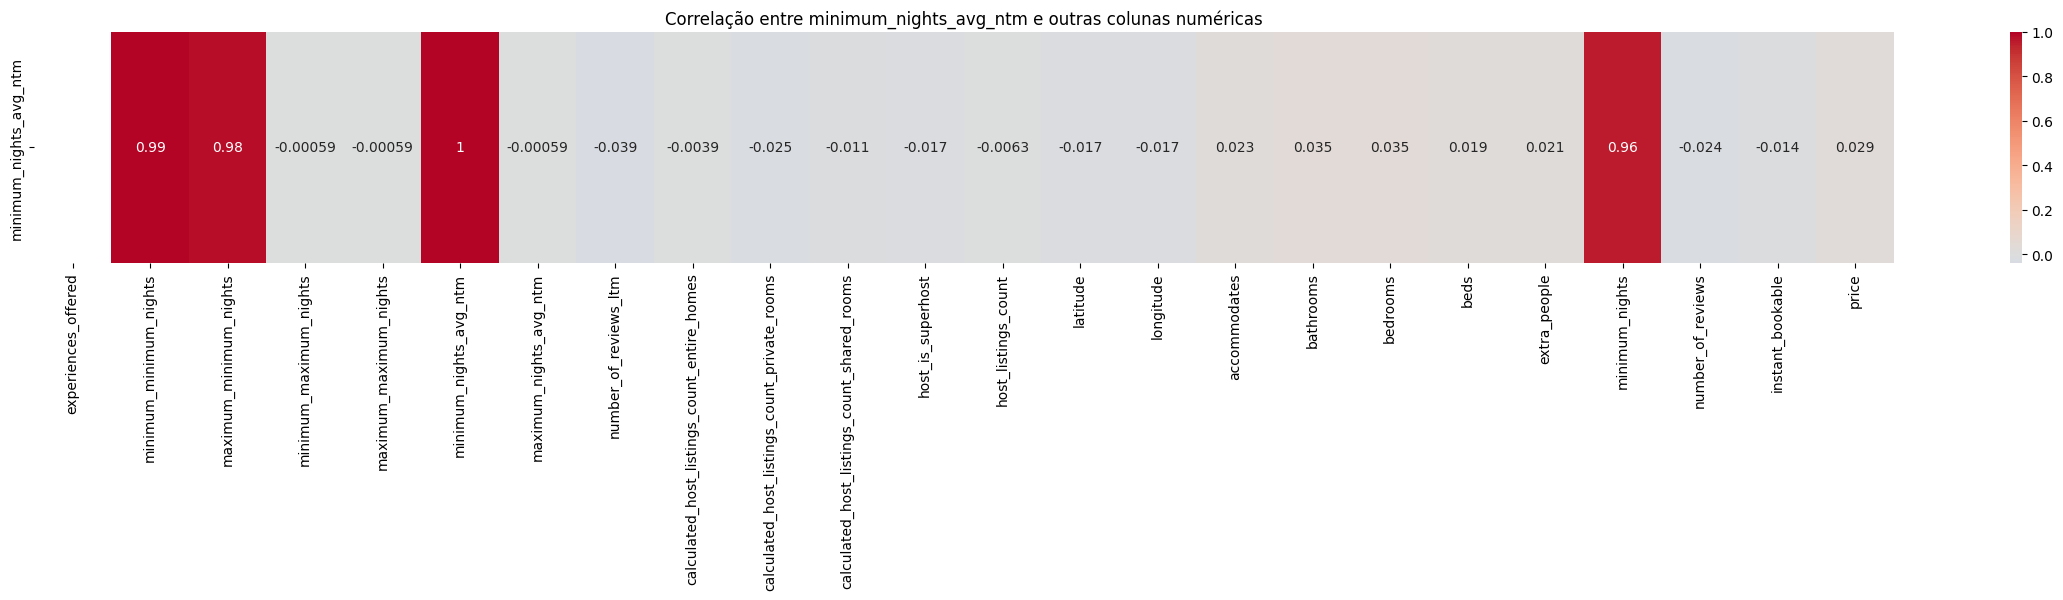

In [ ]:
# Verificar a correlação entre as colunas
# Filtrar apenas colunas numéricas
numeric_columns = train.select_dtypes(include=[float, int]).columns
numeric_train = train[numeric_columns]

# Calcular a matriz de correlação
corr_matrix = numeric_train.corr()

# Extrair apenas a linha correspondente à coluna 'maximum_nights_avg_ntm'
max_nights_corr = corr_matrix[['minimum_nights_avg_ntm']]

# Plotar um heatmap para a correlação de 'maximum_nights_avg_ntm' com outras colunas
plt.figure(figsize=(30,3))
sns.heatmap(max_nights_corr.T, annot=True, cmap='coolwarm', center=0)
plt.title('Correlação entre minimum_nights_avg_ntm e outras colunas numéricas')
plt.show()

In [ ]:
# Selecionar apenas as linhas com todas as colunas preenchidas
train_data = train.dropna(subset=['minimum_nights_avg_ntm'])

# Definir as variáveis independentes (X) e dependente (y)
X_train_minimum = train_data[['minimum_minimum_nights', 'maximum_minimum_nights']]
y_train_minimum = train_data['minimum_nights_avg_ntm']

# Treinar o modelo de regressão linear
linear_model_minimum = LinearRegression()
linear_model_minimum.fit(X_train_minimum, y_train_minimum)

LinearRegression()

In [ ]:
# Selecionar as linhas com valores em branco em 'minimum_nights_avg_ntm'
missing_data = train[train['minimum_nights_avg_ntm'].isna()]

# Definir as variáveis independentes (X) para essas linhas
X_missing = missing_data[['minimum_minimum_nights', 'maximum_minimum_nights']]

# Prever os valores em branco
predicted_values = linear_model_minimum.predict(X_missing)

# Preencher os valores previstos na coluna original
train.loc[train['minimum_nights_avg_ntm'].isna(), 'minimum_nights_avg_ntm'] = predicted_values

##### maximum_nights_avg_ntm

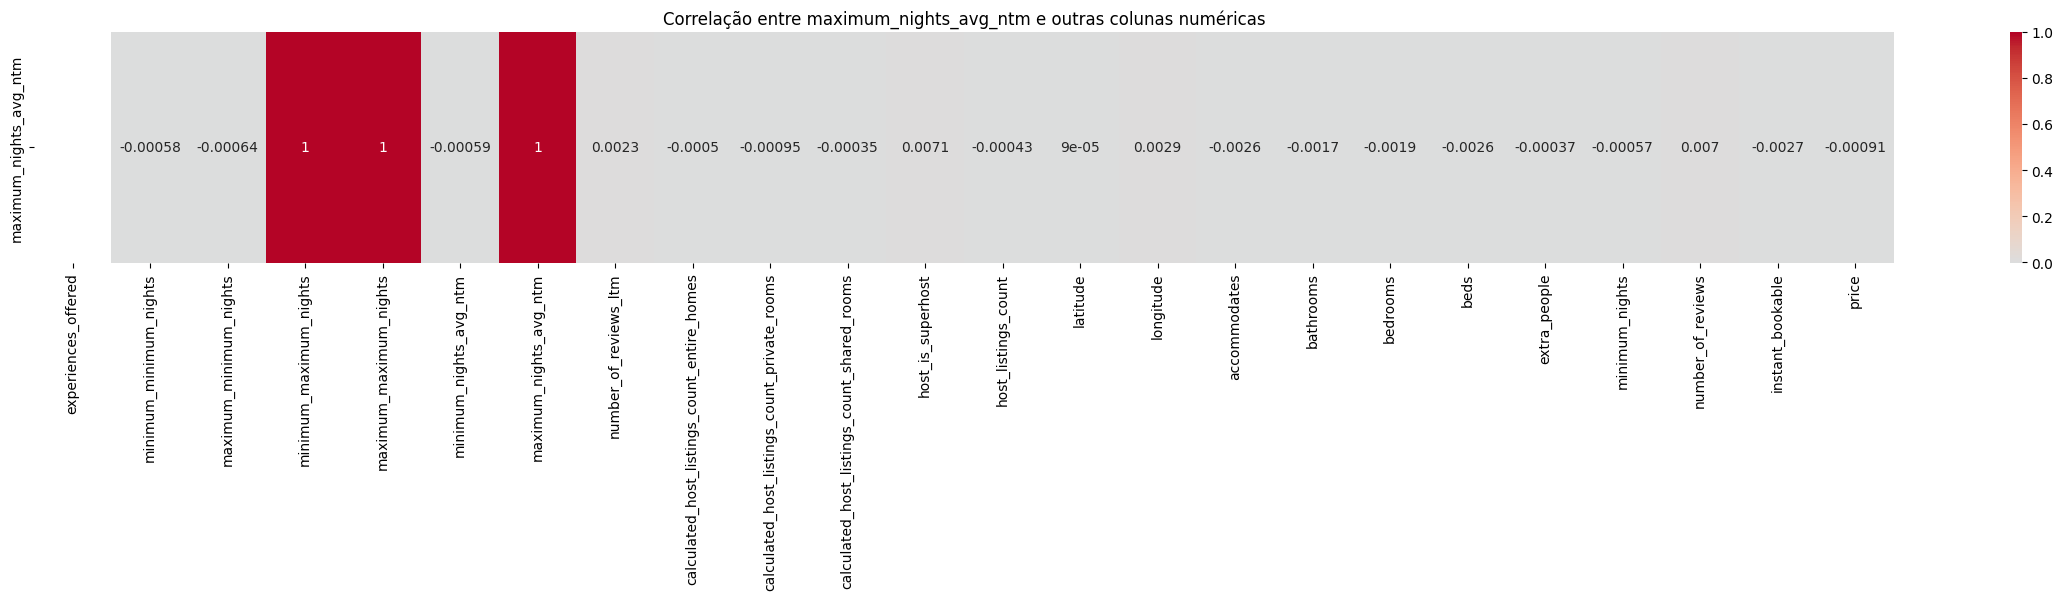

In [ ]:
# Verificar a correlação entre as colunas
# Filtrar apenas colunas numéricas
numeric_columns = train.select_dtypes(include=[float, int]).columns
numeric_train = train[numeric_columns]

# Calcular a matriz de correlação
corr_matrix = numeric_train.corr()

# Extrair apenas a linha correspondente à coluna 'maximum_nights_avg_ntm'
max_nights_corr = corr_matrix[['maximum_nights_avg_ntm']]

# Plotar um heatmap para a correlação de 'maximum_nights_avg_ntm' com outras colunas
plt.figure(figsize=(30,3))
sns.heatmap(max_nights_corr.T, annot=True, cmap='coolwarm', center=0)
plt.title('Correlação entre maximum_nights_avg_ntm e outras colunas numéricas')
plt.show()

In [ ]:
# Selecionar apenas as linhas com todas as colunas preenchidas
train_data = train.dropna(subset=['maximum_nights_avg_ntm'])

# Definir as variáveis independentes (X) e dependente (y)
X_train_maximum = train_data[['minimum_maximum_nights', 'maximum_maximum_nights']]
y_train_maximum = train_data['maximum_nights_avg_ntm']

# Treinar o modelo de regressão linear
linear_model_maximum = LinearRegression()
linear_model_maximum.fit(X_train_maximum, y_train_maximum)

LinearRegression()

In [ ]:
# Selecionar as linhas com valores em branco em 'maximum_nights_avg_ntm'
missing_data = train[train['maximum_nights_avg_ntm'].isna()]

# Definir as variáveis independentes (X) para essas linhas
X_missing = missing_data[['minimum_maximum_nights', 'maximum_maximum_nights']]

# Prever os valores em branco
predicted_values = linear_model_maximum.predict(X_missing)

# Preencher os valores previstos na coluna original
train.loc[train['maximum_nights_avg_ntm'].isna(), 'maximum_nights_avg_ntm'] = predicted_values

##### host_listings_count

<ipython-input-16-4e2a2a73799b>:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train['host_listings_count'], shade=True, color='blue')


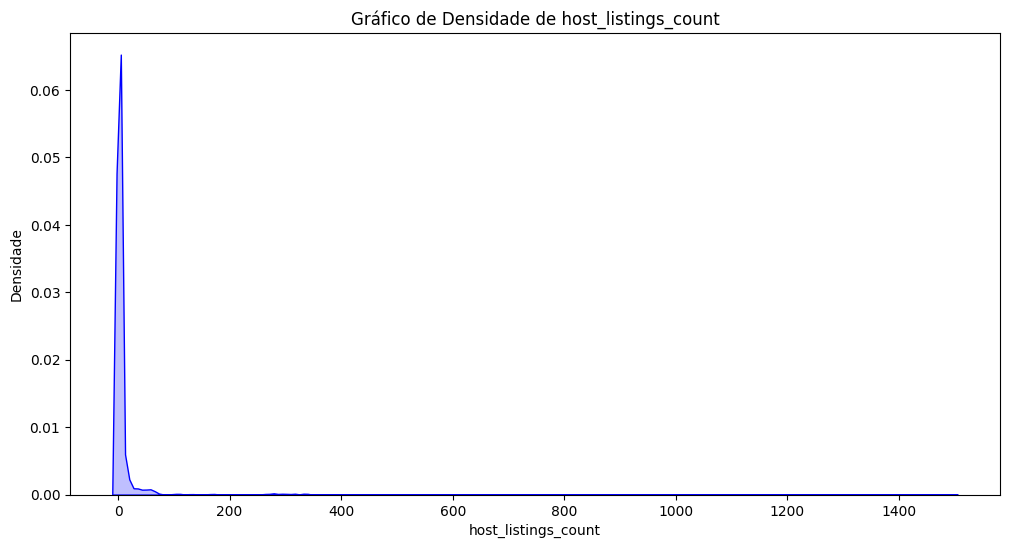

In [ ]:
# Criar um histograma e um gráfico de densidade para 'host_listings_count'
plt.figure(figsize=(12, 6))

# Gráfico de Densidade
sns.kdeplot(train['host_listings_count'], shade=True, color='blue')
plt.title('Gráfico de Densidade de host_listings_count')
plt.xlabel('host_listings_count')
plt.ylabel('Densidade')

# Mostrar o gráfico
plt.show()
print()

In [ ]:
train = train.dropna(subset=['host_listings_count'])

# Calcular a média e a mediana
mean_host_listing = train['host_listings_count'].mean()
median_host_listing = train['host_listings_count'].median()

# Contar o número de valores iguais à média e à mediana
count_mean = (train['host_listings_count'] == mean_host_listing).sum()
count_median = (train['host_listings_count'] == median_host_listing).sum()

# Calcular o total de valores na coluna
total_count = len(train)

# Calcular as porcentagens
percentage_mean = (count_mean / total_count) * 100
percentage_median = (count_median / total_count) * 100

# Mostrar os resultados
print(f"Média da coluna 'host_listings_count': {mean_host_listing:.2f}")
print(f"Mediana da coluna 'host_listings_count': {median_host_listing:.2f}")
print(f"Porcentagem de valores iguais à média: {percentage_mean:.2f}%")
print(f"Porcentagem de valores iguais à mediana: {percentage_median:.2f}%")

Média da coluna 'host_listings_count': 8.73
Mediana da coluna 'host_listings_count': 1.00
Porcentagem de valores iguais à média: 0.00%
Porcentagem de valores iguais à mediana: 53.49%


In [ ]:
train['host_listings_count'] = train['host_listings_count'].fillna(median_host_listing)

<ipython-input-18-0c38677ed452>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['host_listings_count'] = train['host_listings_count'].fillna(median_host_listing)


##### Resultado

In [ ]:
# Mostrar informações do DataFrame
train.info()

# Mostrar porcentagem de linhas com valores em branco
total_rows = len(train)
rows_with_nulls = train.isnull().any(axis=1).sum()
percentage_rows_with_nulls = (rows_with_nulls / total_rows) * 100

print(f"Porcentagem de linhas com algum valor em branco: {percentage_rows_with_nulls:.2f}%")

# Criar tabela de porcentagem de valores em branco por coluna
null_percentage_per_column = train.isnull().mean() * 100
null_percentage_train = null_percentage_per_column.reset_index()
null_percentage_train.columns = ['Column', 'Percentage of Nulls']

print(null_percentage_train)

<class 'pandas.core.frame.DataFrame'>
Index: 587796 entries, 0 to 588090
Data columns (total 29 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   id                                            587796 non-null  object 
 1   experiences_offered                           587796 non-null  int64  
 2   minimum_minimum_nights                        587796 non-null  int64  
 3   maximum_minimum_nights                        587796 non-null  int64  
 4   minimum_maximum_nights                        587796 non-null  int64  
 5   maximum_maximum_nights                        587796 non-null  int64  
 6   minimum_nights_avg_ntm                        587796 non-null  float64
 7   maximum_nights_avg_ntm                        587796 non-null  float64
 8   number_of_reviews_ltm                         587796 non-null  int64  
 9   calculated_host_listings_count_entire_homes   587796 

#### Tratar dados de texto

##### amenities

In [ ]:
print(train['amenities'].unique())

['{Internet,Wifi,Kitchen,"Free parking on premises",Breakfast,"Family/kid friendly",Washer,Dryer}'
 '{TV,"Cable TV",Internet,Wifi,"Air conditioning",Kitchen,"Free parking on premises","Smoking allowed",Doorman,Gym,Elevator,"Buzzer/wireless intercom","Family/kid friendly",Washer,Dryer,"Fire extinguisher"}'
 '{TV,"Air conditioning",Pool,Kitchen,"Free parking on premises","Smoking allowed",Gym,Elevator,"Family/kid friendly","Suitable for events",Washer,Essentials,Shampoo,"Lock on bedroom door",Hangers,"Hair dryer",Iron,"Laptop friendly workspace"}'
 ...
 '{TV,Wifi,"Air conditioning",Pool,"Free parking on premises",Breakfast,Elevator,"Hot tub",Heating,Washer,"Carbon monoxide detector","Fire extinguisher",Essentials,Shampoo,"Lock on bedroom door",Hangers,Iron,"Private entrance"}'
 '{TV,Internet,Wifi,"Air conditioning",Pool,Kitchen,"Free parking on premises","Smoking allowed","Pets allowed",Gym,Elevator,"Free street parking","Suitable for events",Washer,"First aid kit","Fire extinguisher",Es

In [ ]:
# Função para converter o texto da coluna 'amenities' em uma lista de amenities
def parse_amenities(amenities_str):
    try:
        amenities_list = ast.literal_eval(amenities_str)  # Converte a string para lista
        return [item.strip('"') for item in amenities_list]  # Remove aspas
    except (ValueError, SyntaxError):
        return []

# Aplicar a função para criar uma nova coluna com listas de amenities
train['amenities_list'] = train['amenities'].apply(parse_amenities)

# Encontrar todas as amenidades únicas
all_amenities = set(amenity for sublist in train['amenities_list'] for amenity in sublist)

# Criar colunas para cada amenidade única
for amenity in all_amenities:
    train[amenity] = train['amenities_list'].apply(lambda x: 1 if amenity in x else 0)

# Remover a coluna original e a coluna intermediária
train = train.drop(['amenities', 'amenities_list'], axis=1)

# Mostrar os primeiros registros para verificar a transformação
print(train.head())

         id  experiences_offered  minimum_minimum_nights  \
0    947924                    0                       0   
1   2747040                    0                      10   
2  13734316                    0                       0   
3  30979175                    0                       2   
4   3742926                    0                       0   

   maximum_minimum_nights  minimum_maximum_nights  maximum_maximum_nights  \
0                       0                       0                       0   
1                      10                      30                      30   
2                       0                       0                       0   
3                       4                      15                      15   
4                       0                       0                       0   

   minimum_nights_avg_ntm  maximum_nights_avg_ntm  number_of_reviews_ltm  \
0               -0.050078                0.015327                      0   
1               10.00000

##### property_type

In [ ]:
print(train['property_type'].unique())

['House' 'Apartment' 'Serviced apartment' 'Condominium' 'Loft'
 'Bed and breakfast' 'Guesthouse' 'Guest suite' 'Hostel' 'Cottage'
 'Aparthotel' 'Hotel' 'Other' 'Casa particular (Cuba)' 'Houseboat'
 'Nature lodge' 'Townhouse' 'Villa' 'Castle' 'Tiny house' 'Earth house'
 'Chalet' 'Cabin' 'Barn' 'Dome house' 'Boat' 'Boutique hotel' 'Treehouse'
 'Bungalow' 'Campsite' 'Farm stay' 'Island' 'Dorm' 'Resort' 'Tent' 'Hut'
 'Yurt' 'Parking Space' 'Tipi' 'Camper/RV' 'Plane' 'Vacation home'
 'Casa particular' 'Train' 'Pension (South Korea)' 'Igloo' 'Lighthouse']


In [ ]:
# Aplicar One Hot Encoding na coluna 'property_type'
property_type_dummies = pd.get_dummies(train['property_type'], prefix='property_type')

# Verificar o tipo de dados dos dummies para garantir que são inteiros
property_type_dummies = property_type_dummies.astype(int)

# Concatenar as novas colunas com o DataFrame original
train = pd.concat([train, property_type_dummies], axis=1)

# Remover a coluna original 'property_type' (opcional, se não for mais necessária)
train = train.drop('property_type', axis=1)

##### room_type

In [ ]:
print(train['room_type'].unique())

['Private room' 'Entire home/apt' 'Shared room' 'Hotel room']


In [ ]:
# Aplicar One Hot Encoding na coluna 'room_type'
room_type_dummies = pd.get_dummies(train['room_type'], prefix='room_type')

# Garantir que os valores sejam 1/0
room_type_dummies = room_type_dummies.astype(int)

# Concatenar as novas colunas com o DataFrame original
train = pd.concat([train, room_type_dummies], axis=1)

# Remover a coluna original 'room_type' (opcional, se não for mais necessária)
train = train.drop('room_type', axis=1)

##### cancellation_policy

In [ ]:
print(train['cancellation_policy'].unique())

['strict_14_with_grace_period' 'moderate' 'flexible' 'super_strict_30'
 'super_strict_60' 'strict']


In [ ]:
# Definir a ordem de encoding
ordinal_mapping = {
    'flexible': 1,
    'moderate': 2,
    'strict': 3,
    'super_strict_30': 4,
    'super_strict_60': 5,
    'strict_14_with_grace_period': 6
}

# Aplicar o Ordinal Encoding
train['cancellation_policy_encoded'] = train['cancellation_policy'].map(ordinal_mapping)

train = train.drop('cancellation_policy', axis=1)

# Mostrar os primeiros registros para verificar a transformação
train.head(10)

,id,experiences_offered,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,number_of_reviews_ltm,calculated_host_listings_count_entire_homes,...,property_type_Train,property_type_Treehouse,property_type_Vacation home,property_type_Villa,property_type_Yurt,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,cancellation_policy_encoded
0,947924,0,0,0,0,0,-0.050078,0.015327,0,0,...,0,0,0,0,0,0,0,1,0,6
1,2747040,0,10,10,30,30,10.000000,30.000000,0,1,...,0,0,0,0,0,1,0,0,0,2
2,13734316,0,0,0,0,0,-0.050078,0.015327,0,0,...,0,0,0,0,0,1,0,0,0,1
3,30979175,0,2,4,15,15,2.400000,15.000000,20,1,...,0,0,0,0,0,1,0,0,0,2
4,3742926,0,0,0,0,0,-0.050078,0.015327,0,0,...,0,0,0,0,0,0,0,1,0,1
5,16038668,0,1,1,1125,1125,1.000000,1125.000000,0,1,...,0,0,0,0,0,1,0,0,0,6
6,12039211,0,2,2,1125,1125,2.000000,1125.000000,1,0,...,0,0,0,0,0,0,0,1,0,6
7,25165747,0,1,1,1125,1125,1.000000,1125.000000,1,1,...,0,0,0,0,0,1,0,0,0,1
8,19787006,0,2,2,89,89,2.000000,89.000000,0,7,...,0,0,0,0,0,1,0,0,0,1
9,26805395,0,3,3,1125,1125,3.000000,1125.000000,9,1,...,0,0,0,0,0,1,0,0,0,1


#### Tratamento de outliers

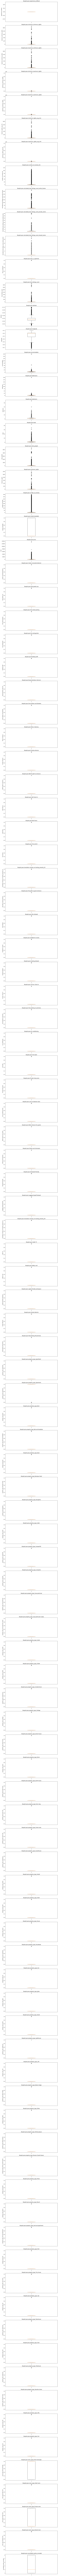

In [ ]:
# Selecionar apenas as colunas numéricas
numeric_columns = train.select_dtypes(include=[np.number])

# Criar uma figura com subplots
fig, axes = plt.subplots(nrows=len(numeric_columns.columns), ncols=1, figsize=(10, len(numeric_columns.columns) * 4))

# Se houver apenas uma coluna, 'axes' será um único objeto e não uma lista
if len(numeric_columns.columns) == 1:
    axes = [axes]

# Criar um boxplot para cada coluna
for ax, column in zip(axes, numeric_columns.columns):
    ax.boxplot(train[column].dropna())  # remove valores nulos
    ax.set_title(f'Boxplot para {column}')
    ax.set_ylabel(column)

# Ajustar o layout
plt.tight_layout()
plt.show()


##Test

#### Limpeza de dados

In [ ]:
# Deletar linhas e colunas em branco
test = test.dropna(axis=1, how='all')
test = test.dropna(axis=0, how='all')

# Deletar colunas irrelevantes para o modelo
test = test.drop(['name', 'summary', 'space', 'description', 'neighborhood_overview', 'listing_url', 'last_scraped', 'scrape_id'], axis=1)

#### Ajuste de formato de dados

In [ ]:
# Ajustar colunas com necessidade de substituição ou retirada de valores
test['instant_bookable'] = test['instant_bookable'].replace({'t': 1, 'f': 0})
test['instant_bookable'] = test['instant_bookable'].fillna(0).astype('int64')

test['experiences_offered'] = test['experiences_offered'].replace('none', 0)
test['experiences_offered'] = test['experiences_offered'].fillna(0).astype('int64')

test['host_is_superhost'] = test['host_is_superhost'].replace({'t': 1, 'f': 0})
test['host_is_superhost'] = test['host_is_superhost'].fillna(0).astype('int64')

test['extra_people'] = test['extra_people'].str.replace('$', '', regex=False)
test['extra_people'] = test['extra_people'].str.replace(',', '', regex=False).astype(float)

test = test[test['accommodates'] != '2019-03-06']
test['accommodates'] = test['accommodates'].fillna(0).astype('int64')



# Ajustar formatos de dados
test['minimum_minimum_nights'] = test['minimum_minimum_nights'].fillna(0).astype('int64')
test['maximum_minimum_nights'] = test['maximum_minimum_nights'].fillna(0).astype('int64')
test['minimum_maximum_nights'] = test['minimum_maximum_nights'].fillna(0).astype('int64')
test['maximum_maximum_nights'] = test['maximum_maximum_nights'].fillna(0).astype('int64')
test['number_of_reviews_ltm'] = test['number_of_reviews_ltm'].fillna(0).astype('int64')
test['calculated_host_listings_count_entire_homes'] = test['calculated_host_listings_count_entire_homes'].fillna(0).astype('int64')
test['calculated_host_listings_count_private_rooms'] = test['calculated_host_listings_count_private_rooms'].fillna(0).astype('int64')
test['calculated_host_listings_count_shared_rooms'] = test['calculated_host_listings_count_shared_rooms'].fillna(0).astype('int64')
test['bathrooms'] = test['bathrooms'].fillna(0).astype('int64')
test['bedrooms'] = test['bedrooms'].fillna(0).astype('int64')
test['beds'] = test['beds'].fillna(0).astype('int64')
test['number_of_reviews'] = test['number_of_reviews'].fillna(0).astype('int64')
test['minimum_nights'] = test['minimum_nights'].fillna(0).astype('int64')
#test['host_listings_count'] = test['host_listings_count'].str.replace(',', '', regex=False).astype(float)


#### Tratamento de dados nulos

In [ ]:
# Mostrar informações do DataFrame
test.info()

# Mostrar porcentagem de linhas com valores em branco
total_rows = len(test)
rows_with_nulls = test.isnull().any(axis=1).sum()
percentage_rows_with_nulls = (rows_with_nulls / total_rows) * 100

print(f"Porcentagem de linhas com algum valor em branco: {percentage_rows_with_nulls:.2f}%")

# Criar tabela de porcentagem de valores em branco por coluna
null_percentage_per_column = test.isnull().mean() * 100
null_percentage_test = null_percentage_per_column.reset_index()
null_percentage_test.columns = ['Column', 'Percentage of Nulls']

print(null_percentage_test)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196030 entries, 0 to 196029
Data columns (total 28 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   id                                            196030 non-null  int64  
 1   experiences_offered                           196030 non-null  int64  
 2   minimum_minimum_nights                        196030 non-null  int64  
 3   maximum_minimum_nights                        196030 non-null  int64  
 4   minimum_maximum_nights                        196030 non-null  int64  
 5   maximum_maximum_nights                        196030 non-null  int64  
 6   minimum_nights_avg_ntm                        149877 non-null  float64
 7   maximum_nights_avg_ntm                        149877 non-null  float64
 8   number_of_reviews_ltm                         196030 non-null  int64  
 9   calculated_host_listings_count_entire_homes   19

##### minimum_nights_avg_ntm

In [ ]:
missing_data_test = test[test['minimum_nights_avg_ntm'].isna()]

# Definir as variáveis independentes (X) para essas linhas
X_missing_test = missing_data_test[['minimum_minimum_nights', 'maximum_minimum_nights']]

# Prever os valores em branco
predicted_values_test = linear_model_minimum.predict(X_missing_test)

# Preencher os valores previstos na coluna original
test.loc[test['minimum_nights_avg_ntm'].isna(), 'minimum_nights_avg_ntm'] = predicted_values_test


##### maximum_nights_avg_ntm

In [ ]:
missing_data_test = test[test['maximum_nights_avg_ntm'].isna()]

# Definir as variáveis independentes (X) para essas linhas
X_missing_test = missing_data_test[['minimum_maximum_nights', 'maximum_maximum_nights']]

# Prever os valores em branco
predicted_values_test = linear_model_maximum.predict(X_missing_test)

# Preencher os valores previstos na coluna original
test.loc[test['maximum_nights_avg_ntm'].isna(), 'maximum_nights_avg_ntm'] = predicted_values_test

##### host_listings_count


In [ ]:
test['host_listings_count'] = test['host_listings_count'].fillna(median_host_listing)

##### Resultado

In [ ]:
test.info()

# Mostrar porcentagem de linhas com valores em branco
total_rows = len(test)
rows_with_nulls = test.isnull().any(axis=1).sum()
percentage_rows_with_nulls = (rows_with_nulls / total_rows) * 100

print(f"Porcentagem de linhas com algum valor em branco: {percentage_rows_with_nulls:.2f}%")


# Criar tabela de porcentagem de valores em branco por coluna
null_percentage_per_column = test.isnull().mean() * 100
null_percentage_test = null_percentage_per_column.reset_index()
null_percentage_test.columns = ['Column', 'Percentage of Nulls']

print(null_percentage_test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196030 entries, 0 to 196029
Data columns (total 28 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   id                                            196030 non-null  int64  
 1   experiences_offered                           196030 non-null  int64  
 2   minimum_minimum_nights                        196030 non-null  int64  
 3   maximum_minimum_nights                        196030 non-null  int64  
 4   minimum_maximum_nights                        196030 non-null  int64  
 5   maximum_maximum_nights                        196030 non-null  int64  
 6   minimum_nights_avg_ntm                        196030 non-null  float64
 7   maximum_nights_avg_ntm                        196030 non-null  float64
 8   number_of_reviews_ltm                         196030 non-null  int64  
 9   calculated_host_listings_count_entire_homes   19

#### Tratar dados de texto

##### amenities

In [ ]:
# Função para converter o texto da coluna 'amenities' em uma lista de amenities
def parse_amenities(amenities_str):
    try:
        amenities_list = ast.literal_eval(amenities_str)  # Converte a string para lista
        return [item.strip('"') for item in amenities_list]  # Remove aspas
    except (ValueError, SyntaxError):
        return []

# Aplicar a função para criar uma nova coluna com listas de amenities
test['amenities_list'] = test['amenities'].apply(parse_amenities)

# Encontrar todas as amenidades únicas
all_amenities = set(amenity for sublist in test['amenities_list'] for amenity in sublist)

# Criar colunas para cada amenidade única
for amenity in all_amenities:
    test[amenity] = test['amenities_list'].apply(lambda x: 1 if amenity in x else 0)

# Remover a coluna original e a coluna intermediária
test = test.drop(['amenities', 'amenities_list'], axis=1)

##### property_type

In [ ]:
# Aplicar One Hot Encoding na coluna 'property_type'
property_type_dummies = pd.get_dummies(test['property_type'], prefix='property_type')

# Garantir que os valores sejam 1/0
property_type_dummies = property_type_dummies.astype(int)

# Concatenar as novas colunas com o DataFrame original
test = pd.concat([test, property_type_dummies], axis=1)

# Remover a coluna original 'property_type' (opcional, se não for mais necessária)
test = test.drop('property_type', axis=1)

##### room_type

In [ ]:
# Aplicar One Hot Encoding na coluna 'room_type'
room_type_dummies = pd.get_dummies(test['room_type'], prefix='room_type')

# Garantir que os valores sejam 1/0
room_type_dummies = room_type_dummies.astype(int)

# Concatenar as novas colunas com o DataFrame original
test = pd.concat([test, room_type_dummies], axis=1)

# Remover a coluna original 'room_type' (opcional, se não for mais necessária)
test = test.drop('room_type', axis=1)

##### cancelation_policy

In [ ]:
# Definir a ordem de encoding
ordinal_mapping = {
    'flexible': 1,
    'moderate': 2,
    'strict': 3,
    'super_strict_30': 4,
    'super_strict_60': 5,
    'strict_14_with_grace_period': 6
}

# Aplicar o Ordinal Encoding
test['cancellation_policy_encoded'] = test['cancellation_policy'].map(ordinal_mapping)

test = test.drop('cancellation_policy', axis=1)

#### Criar colunas faltantes

In [ ]:


# Identificar as colunas que estão em 'train' mas não em 'test'
missing_columns = [col for col in train.columns if col not in test.columns and col != 'price']

# Adicionar as colunas faltantes ao DataFrame 'test' e preenchê-las com 0
for col in missing_columns:
    test[col] = 0

# Verificar se as colunas foram adicionadas corretamente
print("Colunas adicionadas:", missing_columns)
print("Colunas no DataFrame 'test' agora:", test.columns)


Colunas adicionadas: ['Flat path to guest entrance', 'Wide entrance for guests', 'property_type_Lighthouse', 'property_type_Plane', 'property_type_Train']
Colunas no DataFrame 'test' agora: Index(['id', 'experiences_offered', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'number_of_reviews_ltm',
       'calculated_host_listings_count_entire_homes',
       ...
       'room_type_Entire home/apt', 'room_type_Hotel room',
       'room_type_Private room', 'room_type_Shared room',
       'cancellation_policy_encoded', 'Flat path to guest entrance',
       'Wide entrance for guests', 'property_type_Lighthouse',
       'property_type_Plane', 'property_type_Train'],
      dtype='object', length=110)


# Análises

## Train

In [ ]:
# Calcular a matriz de correlação
corr_matrix = train.corr()


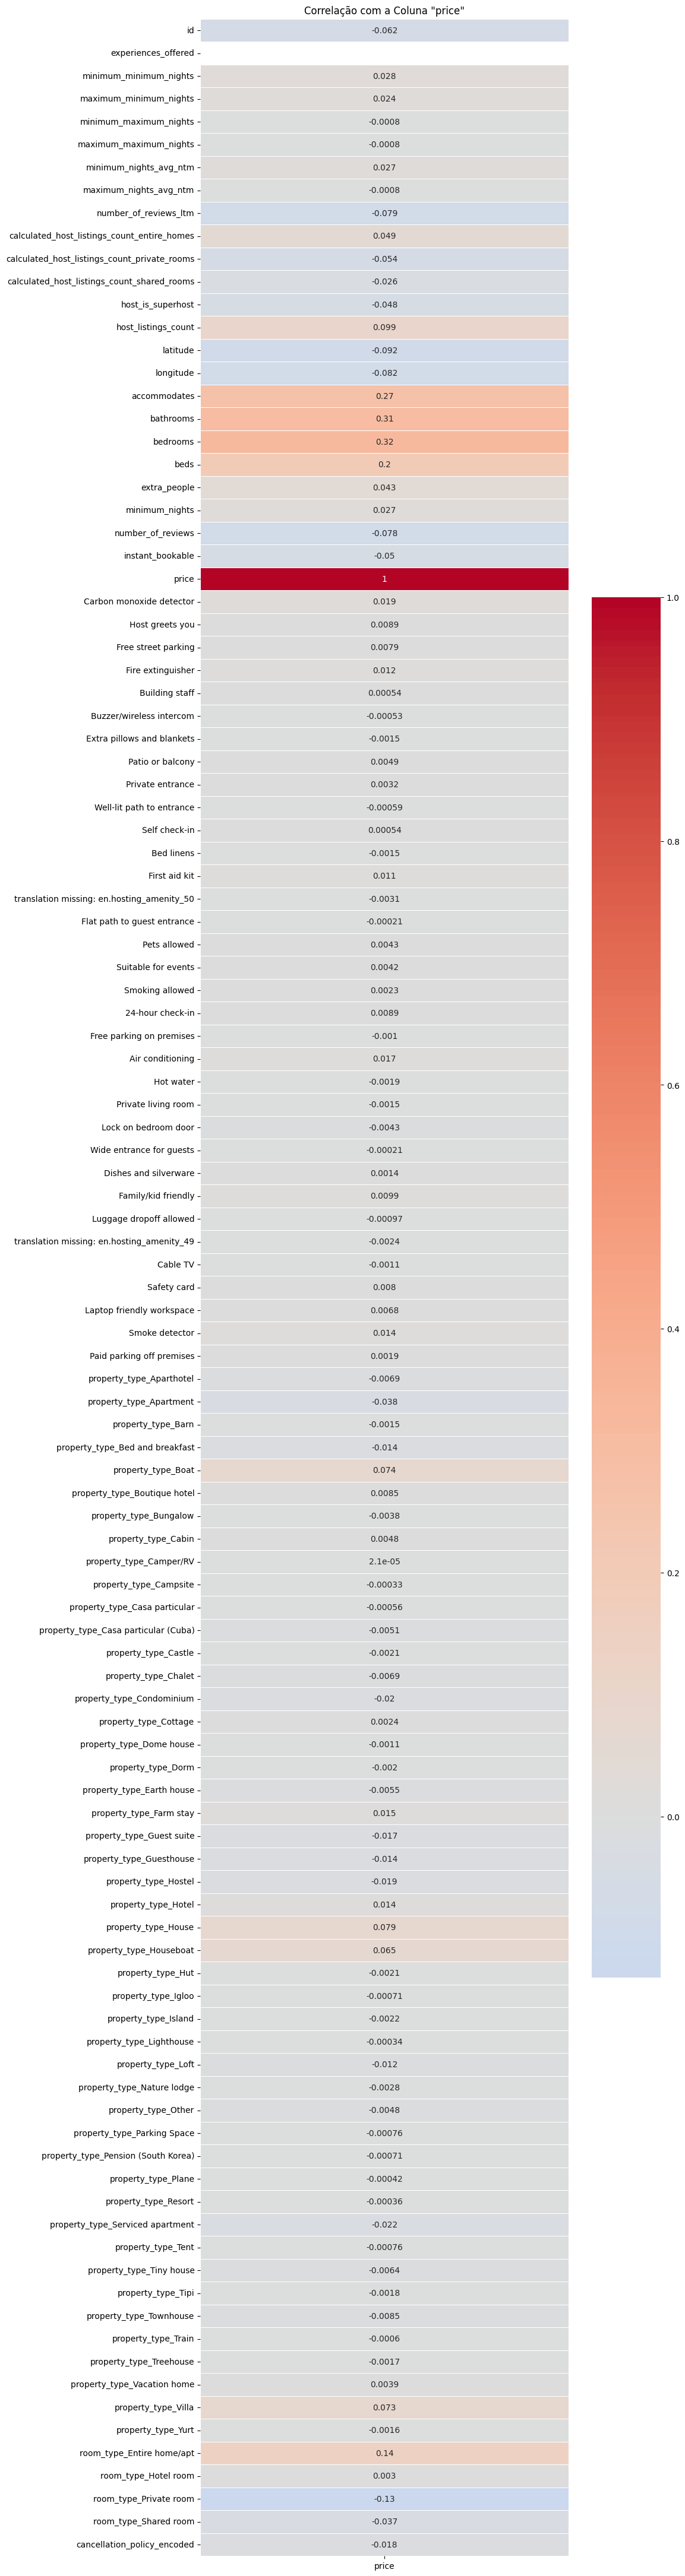

In [ ]:
# Extrair apenas a linha correspondente à coluna 'price'
price_corr = corr_matrix[['price']]

# Configurar o tamanho do gráfico
plt.figure(figsize=(10, len(price_corr) * 0.5))  # Ajuste o tamanho conforme necessário

# Plotar o heatmap para a correlação de 'price'
sns.heatmap(price_corr, annot=True, cmap='coolwarm', center=0, linewidths=0.5)

# Adicionar título
plt.title('Correlação com a Coluna "price"')

# Mostrar o gráfico
plt.show()

# Modelos

## Regressão Linear Inicial

Mean Squared Error: 2267449.7650267137
R^2 Score: 0.1590471210036115


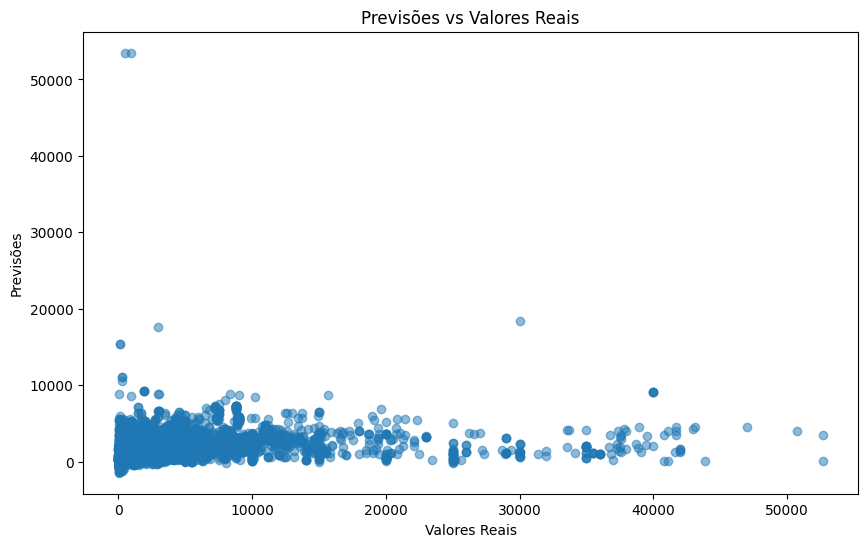

In [ ]:
# Supondo que 'train' é seu DataFrame e que todas as colunas categóricas já foram codificadas

# Dividir os dados em variáveis independentes (X) e dependente (y)
X = train.drop(columns=['price'])
y = train['price']

# Dividir os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Criar o modelo de regressão linear
linear_model = LinearRegression()

# Treinar o modelo
linear_model.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred = linear_model.predict(X_test)

# Avaliar o modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

# Opcional: Visualizar as previsões vs valores reais
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Valores Reais')
plt.ylabel('Previsões')
plt.title('Previsões vs Valores Reais')
plt.show()

## Regressão Linear com valores normalizados

Valores normalizados com Min-Max Scaling, em um range de [-1,1]

In [ ]:
import pandas as pd
import numpy as np

# Função para normalizar as colunas utilizando Min-Max Scaling no intervalo [-1, 1]
def min_max_scaling(column):
    if pd.api.types.is_numeric_dtype(column):  # Verifica se a coluna é numérica
        min_val = column.min()
        max_val = column.max()
        if min_val != max_val:  # Evita divisão por zero
            return 2 * ((column - min_val) / (max_val - min_val)) - 1
        else:
            return column  # Se todos os valores são iguais, retorna a coluna original
    else:
        return column  # Retorna a coluna original se não for numérica

# Selecionar apenas colunas numéricas
numeric_columns = train.select_dtypes(include=[np.number])

# Aplicar a normalização apenas nas colunas numéricas
normalized_numeric_columns = numeric_columns.apply(min_max_scaling)

# Substituir as colunas numéricas normalizadas no DataFrame original
normalized_train = train.copy()
normalized_train[numeric_columns.columns] = normalized_numeric_columns

# Manter a coluna 'price' sem alterações
normalized_train['price'] = train['price']

In [ ]:
# Supondo que a coluna alvo (target) é 'target_column'
# Separe as variáveis independentes e dependentes
X = normalized_train.drop('price', axis=1)  # Variáveis independentes
y = normalized_train['price']  # Variável dependente

# Dividir o conjunto de dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Criar e treinar o modelo de regressão
model = LinearRegression()
model.fit(X_train, y_train)

# Fazer previsões
y_pred = model.predict(X_test)

# Avaliar o modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 2267487.6245400924
R^2 Score: 0.15903307964875357


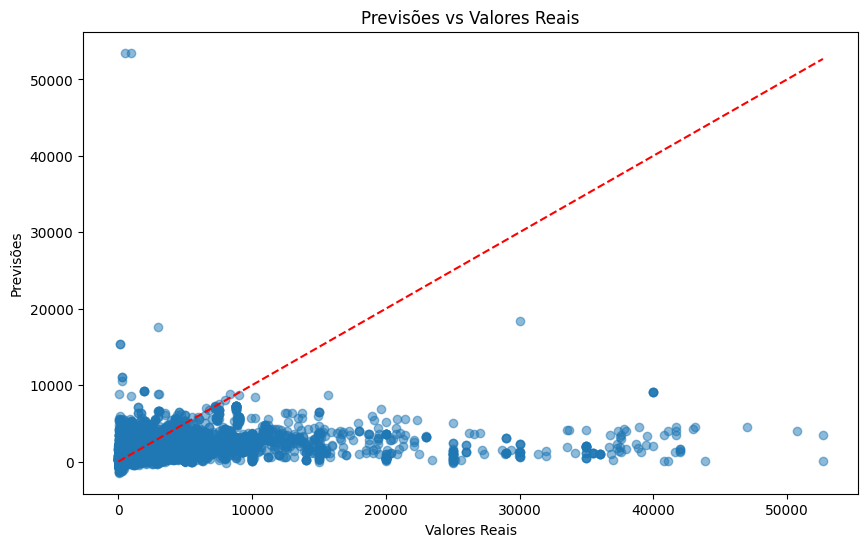

In [ ]:
# Opcional: Visualizar as previsões vs valores reais
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Valores Reais')
plt.ylabel('Previsões')
plt.title('Previsões vs Valores Reais')

# Adicionar linha de referência para visualização
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')

plt.show()

## Random Forest

Mean Squared Error: 148358.65724280843
R^2 Score: 0.9449766685653967


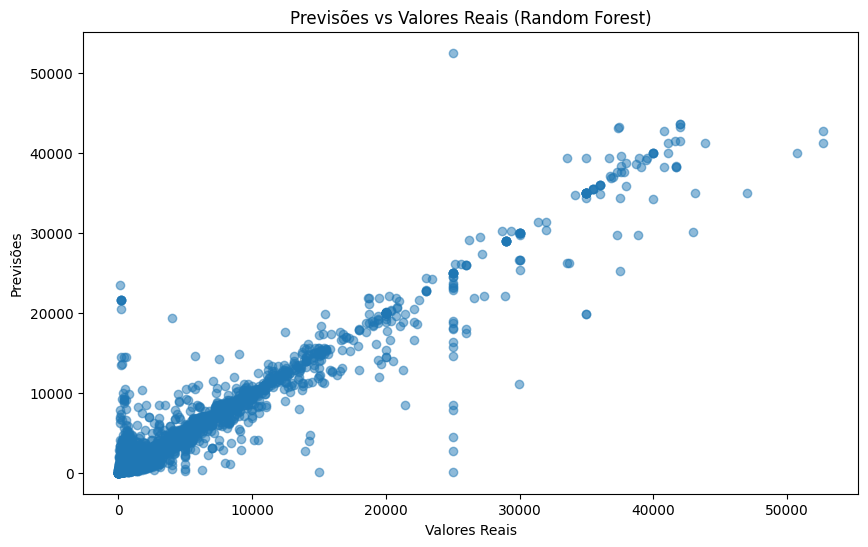

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Supondo que 'train' é seu DataFrame e que todas as colunas categóricas já foram codificadas

# Dividir os dados em variáveis independentes (X) e dependente (y)
X = train.drop(columns=['price'])
y = train['price']

# Dividir os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Criar o modelo de Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Treinar o modelo
rf_model.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred = rf_model.predict(X_test)

# Avaliar o modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

# Opcional: Visualizar as previsões vs valores reais
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Valores Reais')
plt.ylabel('Previsões')
plt.title('Previsões vs Valores Reais (Random Forest)')
plt.show()


# Aplicação

In [ ]:
# Obter a lista de colunas do DataFrame de treinamento
columns_train = X_train.columns

# Garantir que o DataFrame 'test' tenha todas as colunas do DataFrame de treinamento
for col in columns_train:
    if col not in test.columns:
        test[col] = 0

# Reordenar as colunas do DataFrame 'test' para que correspondam à ordem do DataFrame de treinamento
test = test[columns_train]

# Fazer previsões na base 'test'
price_predictions = rf_model.predict(test)

# Adicionar as previsões ao DataFrame 'test'
test['price'] = price_predictions


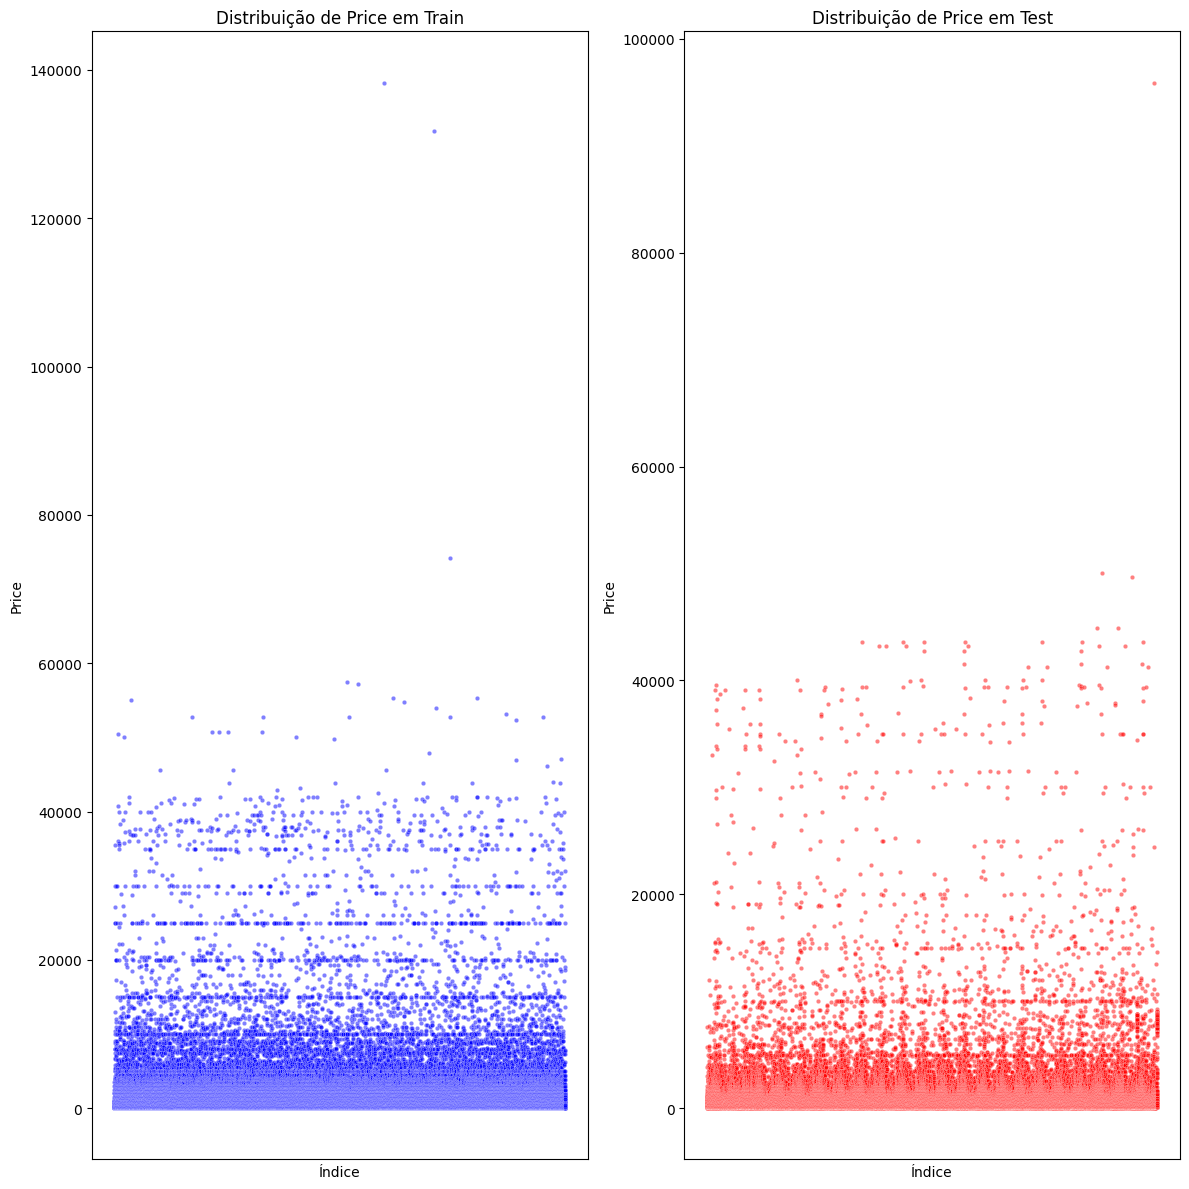

In [ ]:
    plt.figure(figsize=(12, 12))

    # Gráfico de bolinhas para a base 'train'
    plt.subplot(1, 2, 1)
    sns.scatterplot(x=train.index, y=train['price'], alpha=0.5, color='blue', s=10)
    plt.title('Distribuição de Price em Train')
    plt.xlabel('Índice')
    plt.ylabel('Price')
    plt.xticks([])  # Ocultar os rótulos do eixo x para clareza

    # Gráfico de bolinhas para a base 'test'
    plt.subplot(1, 2, 2)
    sns.scatterplot(x=test.index, y=test['price'], alpha=0.5, color='red', s=10)
    plt.title('Distribuição de Price em Test')
    plt.xlabel('Índice')
    plt.ylabel('Price')
    plt.xticks([])  # Ocultar os rótulos do eixo x para clareza

    plt.tight_layout()
    plt.show()


In [ ]:
    test_filtered = test[['id', 'price']]

    # Exportar para um arquivo CSV
    test_filtered.to_csv('test_with_price_predictions.csv', index=False)

In [ ]:
test_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196030 entries, 0 to 196029
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      196030 non-null  int64  
 1   price   196030 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 3.0 MB
